<a href="https://colab.research.google.com/github/aaalexlit/tf-advanced-techniques-spec/blob/main/course_1_custom_models/Week5_Custom_Callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import Callback, LambdaCallback

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.9.2


In [2]:
def get_model():
  model = Sequential([
      Dense(1, activation='linear', input_dim = 784),
  ])
  model.compile(optimizer=RMSprop(learning_rate=0.1),
                loss='mean_squared_error',
                metrics=['mae'])
  return model

# Prepare the data

In [3]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


# Simple custom callback inheriting from `tensorflow.keras.callbacks.Callback`

In [4]:
class MyCustomCallback(Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print(f'Training: batch {batch} begins at {datetime.datetime.now().time()}')

    def on_train_batch_end(self, batch, logs=None):
        print(f'Training: batch {batch} ends at {datetime.datetime.now().time()}')

In [5]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training: batch 0 begins at 05:20:57.552866
Training: batch 0 ends at 05:20:58.155665
Training: batch 1 begins at 05:20:58.156152
Training: batch 1 ends at 05:20:58.158839
Training: batch 2 begins at 05:20:58.159183
Training: batch 2 ends at 05:20:58.161571
Training: batch 3 begins at 05:20:58.161905
Training: batch 3 ends at 05:20:58.163542
Training: batch 4 begins at 05:20:58.163913
Training: batch 4 ends at 05:20:58.166627


# LambdaCallback using `logs` dict

The `logs` dict contains the loss value, and all the metrics at the end of a batch or epoch. Example includes the loss and mean absolute error.

In [6]:
callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs:
    print(f"\nEpoch {epoch}, Val/Train loss ratio: {logs['val_loss']/logs['loss']:.2f} ")
)

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=10,
              callbacks=[callback])

Epoch 1/10
930/938 [============================>.] - ETA: 0s - loss: 33.1042 - mae: 4.7569
Epoch 0, Val/Train loss ratio: 1.32 
938/938 [==============================] - 4s 4ms/step - loss: 33.1436 - mae: 4.7599 - val_loss: 43.8311 - val_mae: 5.9983
Epoch 2/10
922/938 [============================>.] - ETA: 0s - loss: 32.2410 - mae: 4.7529
Epoch 1, Val/Train loss ratio: 0.41 
938/938 [==============================] - 4s 4ms/step - loss: 32.3130 - mae: 4.7611 - val_loss: 13.3407 - val_mae: 3.0682
Epoch 3/10
930/938 [============================>.] - ETA: 0s - loss: 32.0423 - mae: 4.6329
Epoch 2, Val/Train loss ratio: 1.13 
938/938 [==============================] - 4s 4ms/step - loss: 32.1455 - mae: 4.6398 - val_loss: 36.3410 - val_mae: 5.4241
Epoch 4/10
931/938 [============================>.] - ETA: 0s - loss: 31.7567 - mae: 4.5187
Epoch 3, Val/Train loss ratio: 0.57 
938/938 [==============================] - 5s 5ms/step - loss: 31.8129 - mae: 4.5265 - val_loss: 18.2282 - val_mae:

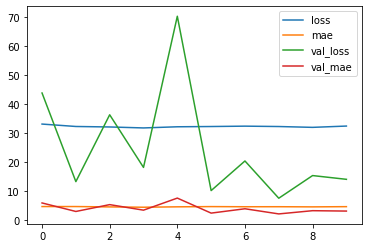

In [7]:
pd.DataFrame(_.history).plot()

# Detect Overfitting Callback

That won't only print the ratio but stop training if it reaches the threshold

In [8]:
class DetectOverfittingCallback(Callback):
  def __init__(self, threshold=0.7):
    super(DetectOverfittingCallback, self).__init__()
    self.threshold = threshold

  def on_epoch_end(self, epoch, logs=None):
    ratio = logs['val_loss']/logs['loss']
    print(f"\nEpoch {epoch}, Val/Train loss ratio: {ratio:.2f} ")

    if ratio > self.threshold:
      print("Stopping training...")
      self.model.stop_training = True

In [9]:
model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])


Epoch 0, Val/Train loss ratio: 0.24 

Epoch 1, Val/Train loss ratio: 2.19 
Stopping training...


# Custom callback to visualize predictions

In [37]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))


def display_digits(inputs, outputs, ground_truth, epoch, n=10):
  # clear current figure
  plt.clf()

  # turn off y ticks and grid
  plt.yticks([])
  plt.grid(None)

  inputs = np.reshape(inputs, [n, 28, 28])
  inputs = np.swapaxes(inputs, 0, 1)
  inputs = np.reshape(inputs, [28, 28*n])
  plt.imshow(inputs)

  plt.xticks([28*x+14 for x in range(n)], outputs)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
      if outputs[i] == ground_truth[i]: 
          t.set_color('green') 
      else: 
          t.set_color('red')
  plt.title(f'Epoch {epoch}')
  plt.grid(None)

In [38]:
GIF_PATH = './animation.gif'

In [39]:
class VisCallback(Callback):
  def __init__(self, inputs, ground_truth, rand=False, display_freq=10, n_samples=10):
    self.inputs = inputs
    self.ground_truth = ground_truth
    self.images = []
    self.display_freq = display_freq
    self.n_samples = n_samples
    self.rand = rand
    if not rand:
      self.indexes = np.random.choice(len(inputs), size=n_samples)

  
  def on_epoch_end(self, epoch, logs=None):
    if self.rand:
      indexes = np.random.choice(len(self.inputs), size=self.n_samples)
    else:
      indexes = self.indexes
    X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
    predictions = np.argmax(self.model.predict(X_test), axis=1)

    # Plot the digits for the current epoch
    display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

    # Save the picture to create the gif after
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = Image.open(buf)
    self.images.append(np.array(image))

    # Display the digits every 'display_freq' number of epochs
    if epoch % self.display_freq == 0:
        plt.show()

  def on_train_end(self, logs=None):
      imageio.mimsave(GIF_PATH, self.images, fps=1)



In [40]:
def get_model():
    model = Sequential()
    model.add(Dense(32, activation='linear', input_dim=784))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

1/1 [==============================] - 0s 45ms/step


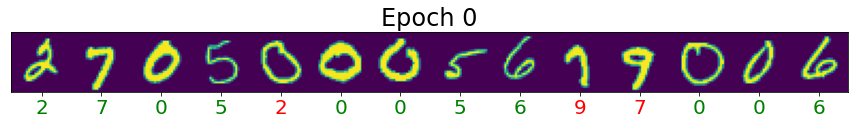

1/1 [==============================] - 0s 26ms/step


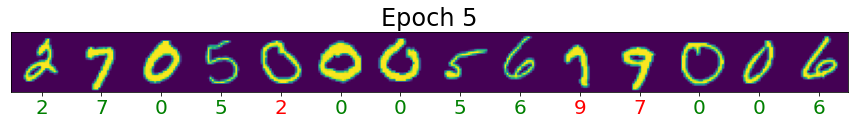

1/1 [==============================] - 0s 21ms/step


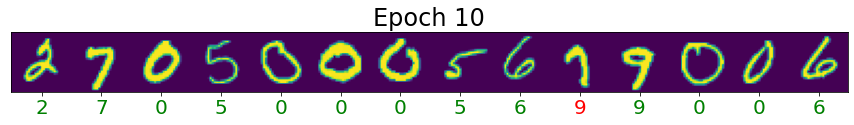

1/1 [==============================] - 0s 24ms/step


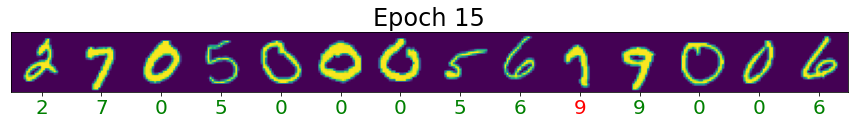

1/1 [==============================] - 0s 19ms/step


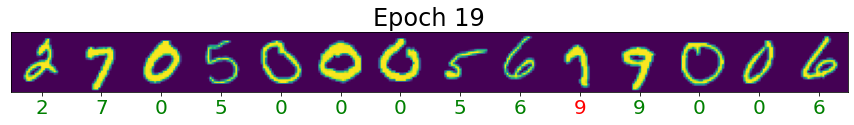

In [45]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test, display_freq=5, n_samples=14)])

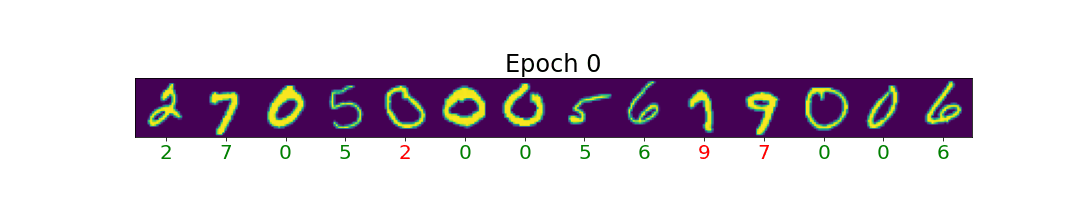

In [46]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE) 